# Training the 2L-SPC on STL-10 database
https://arxiv.org/abs/2002.00892

In [1]:

import sys
from pathlib import Path

sys.path.append(str((Path("..").resolve().absolute())))

from  SPC_2L.DataTools import DataBase
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_Lasso,ML_FISTA
from SPC_2L.DataTools import DataBase, gaussian_kernel
from SPC_2L.Monitor import Monitor
from SPC_2L.Optimizers import mySGD, myAdam
import torch.nn.functional as f
import torch.nn as nn
import torch
import time
import tensorboardX
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torchvision.utils import make_grid
import numpy as np
from tensorboardX import SummaryWriter
import pickle
from torchvision.transforms import ToTensor, Compose, Resize
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import math
from torchvision.datasets import STL10
from matplotlib import pyplot as plt


## Tools, parameters and database

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Files already downloaded and verified


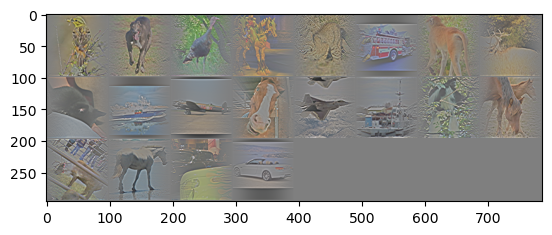

In [14]:

## Database 
data_path = '../data/STL/stl10_binary/'

transform = Compose([ToTensor(),
                    to_cuda(),
                    whitening((96,96),f_0=0.5),
                    Resize((96,96)),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((96,96))
                    ])

dataset = STL10(data_path, transform=transform, download=True, split='train')

DataBase = DataLoader(dataset, batch_size=20, shuffle=False, drop_last=True)
for batch in DataBase:
    images = batch[0].cpu()
    imshow(make_grid(images))
    break

## Gaussian masks for the dictionaries
mask_g = [gaussian_kernel((64,3,8,8), sigma=30), gaussian_kernel((128,64,8,8), sigma=30)]

## Setting parameters
l_r = [1e-4,5e-3]#### dictionaries learning rate [Layer1, Layer2]
l_rv = [1e-3,1e-3]#### normalizer learning rate [Layer1, Layer2]
l = [0.4,1.6]#### Sparsity parameters [Layer1, Layer2]
b=1 #### Feedback strength parameter. b=0 --> Hila, b=1 --> 2L-SPC
v_i=[10,10] #### Initial normalizer value [Layer1, Layer2]
nb_epoch = 100 #### number of training epochs

Use_tb = True #### Use to activate tensorboard monitoring
save = False #### Use to run the entire simulation : TAKE HOURS. Use False to load previous simulation



## Training and saving the network (b=0 for Hi-La, b=1 for 2L-SPC)

In [4]:

## Definition of the layers, network and sparse coding algorithm
layer = [LayerPC((64, 3, 8, 8), stride=2, b=b, v=v_i[0], v_size=64 ,out_pad=0),
        LayerPC((128, 64, 8, 8), stride=1, b=b, v=v_i[1], v_size=128 ,out_pad=0)]

Net = Network(layer, input_size=(20, 3, 96,96))
Loss = ML_Lasso(Net, [l[0],l[1]])
Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=1e-4, mode='eigen')

## Optimizer initialization
opt_dico = [None] * (Net.nb_layers + 1)
for i in range(0, Net.nb_layers):
    opt_dico[i] = mySGD([{'params': Net.layers[i].dico}], lr=l_r[i], momentum=0.9, normalize=True)

opt_v = [myAdam([{'params': Net.layers[i].v}], lr=l_rv[i], normalize=False) \
    for i in range(Net.nb_layers)]


L = [None] * (Net.nb_layers)
L_v = [None] * (Net.nb_layers)
reco = [None] * (Net.nb_layers)

model_name = 'STL_[{0},{1}]_b={2}'.format(l[0],l[1],b)
path = 'Savings/STL/' + model_name +'.pkl'
if Use_tb : 
    nrows = [8,8,8,8,8,8,8]
    writer = SummaryWriter('Savings/Log/' + model_name)
    M = Monitor(Net, writer, n_row=nrows)

k=0

l2_loss = torch.zeros(2,nb_epoch*len(DataBase))
l1_loss = torch.zeros(2,nb_epoch*len(DataBase))
if save == True : 
    for e in range(nb_epoch):
        for idx_batch, data in enumerate(DataBase):

            batch = data[0].cuda()
            gamma, it, Loss_G, delta = Pursuit.coding(batch)


            for i in range(Net.nb_layers):
                Net.layers[i].dico.requires_grad = True
                L[i] = Loss.F(batch, gamma, i, do_feedback=False).div(batch.size()[0])  ## Unsupervised
                L[i].backward()
                Net.layers[i].dico.requires_grad = False
                opt_dico[i].step()
                opt_dico[i].zero_grad()

                ##Mask
                Net.layers[i].dico*=mask_g[i]
                Net.layers[i].dico/=norm(Net.layers[i].dico)
                
                l2_loss[i,k]= L[i].detach() 
                l1_loss[i,k] =  gamma[i].detach().sum().div(gamma[i].size(0))
                

            for i in range(Net.nb_layers):
                Net.layers[i].v.requires_grad = True  # turn_on(i)
                L_v[i] = Loss.F_v(batch, gamma, i).div(batch.size()[0])
                L_v[i].backward()
                Net.layers[i].v.requires_grad = False  # turn_off(i)
                opt_v[i].step()  
                opt_v[i].zero_grad()
                
            if Use_tb:
                if (k%10) == 0:
                    writer.add_scalar('FISTA_iterations', it, k)
                    M.MonitorGamma(gamma, k, option=['NNZ', '%', 'Sum', 'V'])
                    M.MonitorList(L, 'Loss_Dico', k)
                    M.MonitorList(L_v, 'Loss_v', k)
                    M.MonitorDicoBP(k)
                    M.ComputeHisto(gamma)

                if (k%100) == 0:
                    reco = [None] * (Net.nb_layers)
                    for i in range(Net.nb_layers-1,-1,-1):
                        reco[i] = gamma[i]
                        for j in range(i, -1, -1):
                            reco[i] = Net.layers[j].backward(reco[i])
                        reco_image = make_grid(reco[i],normalize=True,pad_value=1)
                        writer.add_image('Reco/L{0}'.format(i),reco_image,k)

            k += 1

    output_exp = {'Net': Net,
            'Loss': Loss,
            'Pursuit': Pursuit,
            'l2_loss': l2_loss,
            'l1_loss': l1_loss    
                 }
    path = 'Savings/STL/' + model_name +'.pkl'
    with open(path, 'wb') as file:
        pickle.dump(output_exp, file, pickle.HIGHEST_PROTOCOL)
    
else :        
    with open(path, 'rb') as file:
        output_exp = pickle.load(file)


NETWORK STRUCTURE : 
 Input : (20, 3, 96, 96)
 Layer 1 : [20, 64, 45, 45]
 Layer 2 : [20, 128, 38, 38]
